In [1]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Data_proc_utils.Data_proc_funcs import *


In [2]:
feature_list_children = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_children_full.list'
feature_list_adults = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_adults_full.list'


def load_and_compute_similarity(feature_list, dtype=np.float32):
    # Load data
    image_names, ids, num_ids, norm_feats = load_magface_vectors(feature_list)

    # Convert dtype to reduce memory usage
    norm_feats = norm_feats.astype(dtype)

    # Compute similarity matrix incrementally if possible
    sim_mat = np.dot(norm_feats, norm_feats.T)

    return image_names, ids, num_ids, sim_mat

# Load and compute for children
image_names_c, ids_c, num_ids_c, sim_mat_c = load_and_compute_similarity(feature_list_children)

# Load and compute for adults
image_names_a, ids_a, num_ids_a, sim_mat_a = load_and_compute_similarity(feature_list_adults)


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv') #erstat med den opdaterede
children_all = children_all[children_all.image_name.isin(image_names_c)]
adults_all = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv') #erstat med den opdaterede
adults_all = adults_all[adults_all.image_name.isin(image_names_a)] # OBS, this operation because some magface images has not been through all adults images.


/data/raw_full/children_full/Asian_366/Asian_366_5.png
/data/raw_full/children_full/Asian_366/Asian_366_2.png
/data/raw_full/children_full/Asian_366/Asian_366_1.png
/data/raw_full/children_full/Asian_366/Asian_366_4.png
/data/raw_full/children_full/Asian_212/Asian_212_6.png
/data/raw_full/children_full/Asian_212/Asian_212_8.png
/data/raw_full/children_full/Asian_212/Asian_212_5.png
/data/raw_full/children_full/Asian_212/Asian_212_2.png
/data/raw_full/children_full/Asian_212/Asian_212_1.png
/data/raw_full/children_full/Asian_212/Asian_212_10.png
/data/raw_full/children_full/African_322/African_322_24.png
/data/raw_full/children_full/African_322/African_322_85.png
/data/raw_full/children_full/African_322/African_322_88.png
/data/raw_full/children_full/African_322/African_322_54.png
/data/raw_full/children_full/Caucasian_1313/Caucasian_1313_11.png
/data/raw_full/children_full/Caucasian_1313/Caucasian_1313_14.png
/data/raw_full/children_full/Caucasian_1313/Caucasian_1313_5.png
/data/raw_fu

In [ ]:
# from Data_proc_utils.Data_proc_funcs import *
# random_states = [42]

# children_balanced_df_1 = balance_child_data(children_all, print_stats=True, random_state=random_states[0])
# adults_balanced_df_1 = balance_adults_data_enrolled(children_balanced_df_1, adults_all, print_stats=True, random_state=random_states[0])


In [3]:
import numpy as np
import pandas as pd



# Function to calculate FNIR and get high threshold list
def GET_SIM_MATRIX_HIGH_TH(enrolled_sim_mat, sim_mat, enrolled_ids, enrolled_num_id, ids, image_names, thold=0.5):
    M_d_set = set(enrolled_ids)
    M_d_set_len = len(enrolled_sim_mat)
    neg_ref = 0
    high_threshold_list = []

    for m_i, id_now in enumerate(ids):
        if id_now in M_d_set:
            mated_ids_exact = [id == id_now for id in ids]
            mated_sim_scores_slice = sim_mat[m_i]
            mated_sim_scores = [(score, image_names[j]) for j, (score, keep) in enumerate(zip(mated_sim_scores_slice, mated_ids_exact)) if keep]
            mated_sim_scores_sorted = sorted(mated_sim_scores, reverse=True, key=lambda x: x[0])
            high_threshold_list.extend([(image_names[m_i], img_name, score) for score, img_name in mated_sim_scores_sorted[:3]])

    for i in range(M_d_set_len):
        probe = enrolled_num_id[i]
        classified_negative_list = enrolled_sim_mat[i] <= thold
        classified_negative_idx = list(np.where(classified_negative_list)[0])
        if probe in [enrolled_num_id[idx] for idx in classified_negative_idx]:
            neg_ref += 1

    fnir = neg_ref / M_d_set_len if M_d_set_len > 0 else 0
    return fnir, high_threshold_list


In [4]:
enrolled_ids_a = ids_a
enrolled_sim_mat_a = sim_mat_a

# ### Compute FNIR and high threshold list
FNIR_a, high_threshold_results_a = GET_SIM_MATRIX_HIGH_TH(
    enrolled_sim_mat_a, sim_mat_a, enrolled_ids_a, num_ids_a, ids_a, image_names_a, thold=0.48)

# print("Children:", high_threshold_results_c)
print("Adults:", high_threshold_results_a)


Adults: [('m.05pnr7_0003', 'm.05pnr7_0003', 1.0), ('m.05pnr7_0003', 'm.05pnr7_0002', 0.54354143), ('m.05pnr7_0003', 'm.05pnr7_0004', 0.4412958), ('m.05pnr7_0002', 'm.05pnr7_0002', 0.9999999), ('m.05pnr7_0002', 'm.05pnr7_0003', 0.54354143), ('m.05pnr7_0002', 'm.05pnr7_0004', 0.47158152), ('m.05pnr7_0001', 'm.05pnr7_0001', 1.0), ('m.05pnr7_0001', 'm.05pnr7_0003', 0.34194666), ('m.05pnr7_0001', 'm.05pnr7_0002', 0.2509334), ('m.05pnr7_0004', 'm.05pnr7_0004', 0.9999995), ('m.05pnr7_0004', 'm.05pnr7_0002', 0.47158152), ('m.05pnr7_0004', 'm.05pnr7_0003', 0.4412958), ('m.0qsc14x_0003', 'm.0qsc14x_0003', 0.9999999), ('m.0qsc14x_0003', 'm.0qsc14x_0002', 0.56949645), ('m.0qsc14x_0003', 'm.0qsc14x_0001', 0.49318), ('m.0qsc14x_0002', 'm.0qsc14x_0002', 1.0000002), ('m.0qsc14x_0002', 'm.0qsc14x_0003', 0.56949645), ('m.0qsc14x_0002', 'm.0qsc14x_0001', 0.40757298), ('m.0qsc14x_0001', 'm.0qsc14x_0001', 1.0), ('m.0qsc14x_0001', 'm.0qsc14x_0003', 0.49318), ('m.0qsc14x_0001', 'm.0qsc14x_0002', 0.40757298),

In [145]:
df = pd.DataFrame(high_threshold_results_a, columns=['Probe Image', 'Reference Image', 'Similarity Score'])

# Filter out rows where the similarity score is greater than 0.9999
df = df[df['Similarity Score'] <= 0.9999]

In [146]:
# Add Identity
df = df.sort_values(by='Similarity Score', ascending=False)
df['Probe Image Identity'] = df['Probe Image'].str.split('_00').str[0]
df['Reference Image Identity'] = df['Reference Image'].str.split('_00').str[0]

In [147]:
# split them in mated and non-mated
mated_df = df[df['Probe Image Identity'] == df['Reference Image Identity']]
non_mated_df = df[df['Probe Image Identity'] != df['Reference Image Identity']]


In [148]:
len(mated_df[mated_df['Similarity Score']>0.5]['Probe Image Identity'].unique())

4322

In [149]:
bible_children = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
len(bible_children.identity_name.unique())

2739

# OFIQ added

In [150]:
OFIQ_a = pd.read_csv('../../data/OFIQ_results/table_adults_all_in_one.csv')
merged_df_probe = pd.merge(mated_df, OFIQ_a, left_on='Probe Image', right_on='image_name')


In [151]:
len(merged_df_probe)

39960

# filtering the worst out

In [152]:
merged_df_probe = merged_df_probe.sort_values(by='Similarity Score', ascending=False)
# The_bottom_identities = merged_df_probe['Probe Image Identity'].tail(9000) # før 11000
# # remove rows if mated_df['Probe Image Identity] in The_bottom_identities

# mask = ~merged_df_probe['Probe Image Identity'].isin(The_bottom_identities)

# # Apply the mask to filter the DataFrame
# filtered_mated_df = merged_df_probe[mask]


In [153]:
# len(filtered_mated_df[filtered_mated_df['Similarity Score']>0.5]['Probe Image Identity'].unique())

In [154]:

# Display or use the filtered DataFrame
# mated_df = filtered_mated_df
# len(mated_df)

In [155]:
# filtered_mated_df = filtered_mated_df.sort_values(by='Similarity Score', ascending=False)

# indices_to_remove = filtered_mated_df.tail(7000).index[1::2]  # Start from the second element and take every second element
# merged_df_probe_0 = filtered_mated_df.drop(indices_to_remove)

# merged_df_probe_0 = merged_df_probe_0.sort_values(by='Similarity Score', ascending=False)


# indices_to_remove = merged_df_probe_0.tail(1500).index[1::2]  # Start from the second element and take every second element
# merged_df_probe = merged_df_probe_0.drop(indices_to_remove)

# filtering based on standard deviation

In [156]:
# først check om det er disse, der er højt korreleret med sim scores
correlation_matrix = merged_df_probe.corr()
print(correlation_matrix['Similarity Score'].sort_values(ascending=False)[:5])

# highest_top = correlation_matrix.drop('Similarity Score', errors='ignore').idxmax()  # Ignore self-correlation


Similarity Score              1.000000
UnifiedQualityScore           0.332018
UnifiedQualityScore.scalar    0.327978
HeadPoseYaw.scalar            0.284910
HeadPoseRoll.scalar           0.204888
Name: Similarity Score, dtype: float64


In [157]:
def remove_outliers(df):
    # Calculate the standard deviation for HeadPoseYaw.scalar and HeadPoseRoll.scalar for each identity
    sd_metrics = df.groupby('Probe Image Identity').agg({
        'HeadPoseYaw.scalar': 'std',
        'HeadPoseRoll.scalar': 'std'
    })

    # Calculate the average SD across all identities for each metric
    avg_yaw_sd = sd_metrics['HeadPoseYaw.scalar'].median()
    avg_roll_sd = sd_metrics['HeadPoseRoll.scalar'].median()

    # Identify identities with SD greater than the average
    high_sd_identities_yaw = sd_metrics[sd_metrics['HeadPoseYaw.scalar'] > avg_yaw_sd].index
    high_sd_identities_roll = sd_metrics[sd_metrics['HeadPoseRoll.scalar'] > avg_roll_sd].index

    # Create an empty list to store indices of rows to drop
    indices_to_drop = []

    # Process each identity with high HeadPoseYaw.scalar SD
    for identity in high_sd_identities_yaw:
        subset = df[df['Probe Image Identity'] == identity]
        mean_value = subset['HeadPoseYaw.scalar'].median()
        subset['diff_from_mean_yaw'] = (subset['HeadPoseYaw.scalar'] - mean_value).abs()
        max_diff_index = subset['diff_from_mean_yaw'].idxmax()
        indices_to_drop.append(max_diff_index)

    # Process each identity with high HeadPoseRoll.scalar SD
    for identity in high_sd_identities_roll:
        subset = df[df['Probe Image Identity'] == identity]
        mean_value = subset['HeadPoseRoll.scalar'].median()
        subset['diff_from_mean_roll'] = (subset['HeadPoseRoll.scalar'] - mean_value).abs()
        max_diff_index = subset['diff_from_mean_roll'].idxmax()
        indices_to_drop.append(max_diff_index)

    # Drop the identified outliers from HeadPoseYaw.scalar and HeadPoseRoll.scalar
    df = df.drop(indices_to_drop)

    # Update list of remaining identities after removing those with high HeadPoseYaw.scalar or HeadPoseRoll.scalar SD
    remaining_identities = set(df['Probe Image Identity']) - set(high_sd_identities_yaw) - set(high_sd_identities_roll)

    # For remaining identities, process based on UnifiedQualityScore.scalar
    for identity in remaining_identities:
        subset = df[df['Probe Image Identity'] == identity]
        if 'UnifiedQualityScore.scalar' in subset.columns:
            neutrality_sd = subset['UnifiedQualityScore.scalar'].std()
            mean_neutrality = subset['UnifiedQualityScore.scalar'].median()
            subset['diff_from_neutrality_mean'] = (subset['UnifiedQualityScore.scalar'] - mean_neutrality).abs()
            max_diff_neutrality_index = subset['diff_from_neutrality_mean'].idxmax()
            df = df.drop(max_diff_neutrality_index)

    return df


In [158]:


df = merged_df_probe
df_cleaned_first = remove_outliers(df)
# df_cleaned = remove_outliers(df_cleaned_first)

/tmp/ipykernel_20179/867153917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['diff_from_mean_yaw'] = (subset['HeadPoseYaw.scalar'] - mean_value).abs()
/tmp/ipykernel_20179/867153917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['diff_from_mean_yaw'] = (subset['HeadPoseYaw.scalar'] - mean_value).abs()
/tmp/ipykernel_20179/867153917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

/tmp/ipykernel_20179/867153917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['diff_from_mean_yaw'] = (subset['HeadPoseYaw.scalar'] - mean_value).abs()
/tmp/ipykernel_20179/867153917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['diff_from_mean_yaw'] = (subset['HeadPoseYaw.scalar'] - mean_value).abs()
/tmp/ipykernel_20179/867153917.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [165]:
df_cleaned_first_1 = df_cleaned_first.sort_values(by='Similarity Score', ascending=False)
The_bottom_identities = df_cleaned_first_1['Probe Image Identity'].tail(5000) # før 11000
# remove rows if mated_df['Probe Image Identity] in The_bottom_identities

mask = ~df_cleaned_first_1['Probe Image Identity'].isin(The_bottom_identities)

# Apply the mask to filter the DataFrame
filtered_mated_df = df_cleaned_first_1[mask]

filtered_mated_df = filtered_mated_df.sort_values(by='Similarity Score', ascending=False)

indices_to_remove = filtered_mated_df.tail(11000).index[1::2]  # Start from the second element and take every second element
merged_df_probe_0 = filtered_mated_df.drop(indices_to_remove)

merged_df_probe_0 = merged_df_probe_0.sort_values(by='Similarity Score', ascending=False)


indices_to_remove = merged_df_probe_0.tail(5000).index[1::2]  # Start from the second element and take every second element
merged_df_probe = merged_df_probe_0.drop(indices_to_remove)

indices_to_remove = merged_df_probe.tail(2500).index[1::2]  # Start from the second element and take every second element
merged_df_probe = merged_df_probe.drop(indices_to_remove)

indices_to_remove = merged_df_probe.tail(1000).index[1::2]  # Start from the second element and take every second element
merged_df_probe = merged_df_probe.drop(indices_to_remove)


In [166]:
len(merged_df_probe['Probe Image Identity'].unique())


3304

# DET

In [167]:
mated_scores1 = merged_df_probe['Similarity Score']
nonmated_scores1 = merged_df_probe['Similarity Score']

from DET_utils.DET import DET
from DET_utils.DET_plots import *

# mated_scores1 = df_cleaned['Similarity Score'][:14000]
# nonmated_scores1 = df_cleaned['Similarity Score'][:14000]

# mated_scores1 = filtered_mated_df['Similarity Score']
# nonmated_scores1 = filtered_mated_df['Similarity Score']

# mated_scores1 = df_cleaned_first['Similarity Score'][:14000]
# nonmated_scores1 = df_cleaned_first['Similarity Score'][:14000]

In [168]:
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
stats_system1_df.round(round_digits).style.hide_index() # 14216.000000     0.580910

/tmp/ipykernel_20179/2559610630.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  stats_system1_df.round(round_digits).style.hide_index() # 14216.000000     0.580910


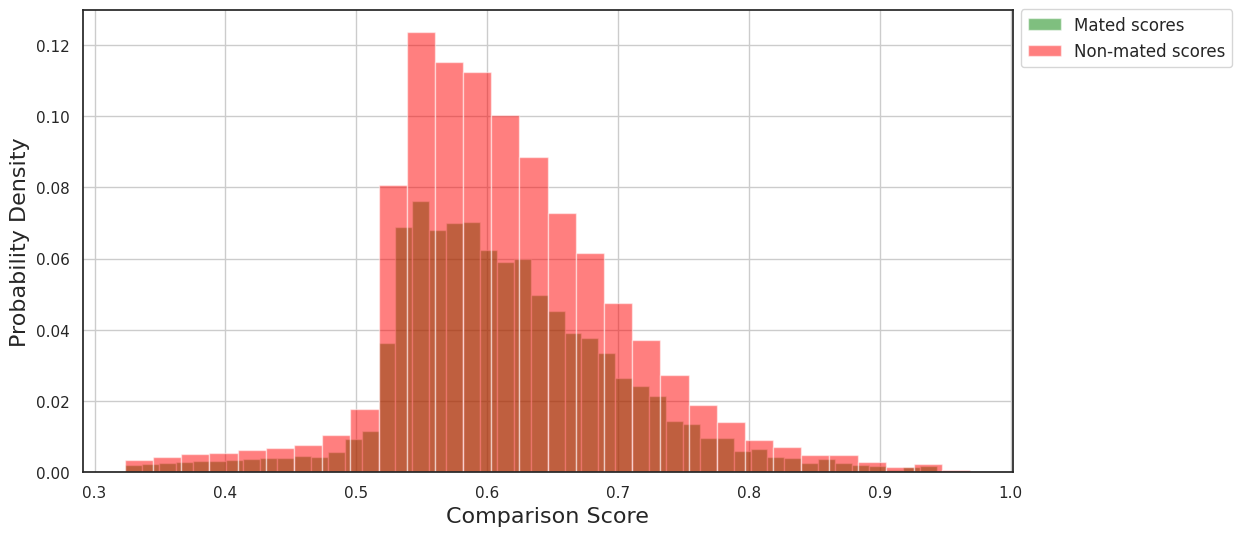

In [169]:
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)

In [170]:
merged_df_probe.to_csv('../../data/image_info_csvs/Image_pairs_similarityscores_OFIQ_worst_dropped.csv')

# Test af om navnene i Image_pairs_similarityscores_OFIQ_worst_dropped.csv stemmer med navnene gennerelt

In [4]:
import pandas as pd
OFIQ_small = pd.read_csv('../../data/image_info_csvs/Image_pairs_similarityscores_OFIQ_worst_dropped.csv')

In [5]:
Bible_adults = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv')

In [6]:
Bible_adults.image_name

0         m.010lz5_0001
1         m.010lz5_0002
2         m.010lz5_0003
3         m.011y5k_0001
4         m.011y5k_0002
              ...      
26258       m.0tj9_0004
26259       m.0tj9_0005
26260    m.0t_d791_0001
26261    m.0t_d791_0002
26262    m.0t_d791_0003
Name: image_name, Length: 26263, dtype: object

In [7]:
OFIQ_small.image_name

0        m.09jvjz_0004
1        m.02hd3q_0003
2        m.0d25cl_0001
3        m.0d25cl_0005
4        m.04d52g_0001
             ...      
7622     m.052nxy_0002
7623    m.02wvdp0_0003
7624     m.0dzsrq_0003
7625     m.0b02zh_0002
7626     m.020nvl_0003
Name: image_name, Length: 7627, dtype: object

In [16]:
Bible_adults['image_name'].isin(OFIQ_small['image_name']).sum()


3189

In [17]:
OFIQ_small['image_name'].isin(Bible_adults['image_name']).sum()


5504

In [18]:
Bible_adults_duplicates = Bible_adults['image_name'].duplicated().sum()
OFIQ_small_duplicates = OFIQ_small['image_name'].duplicated().sum()
print(f"Bible_adults duplicates: {Bible_adults_duplicates}")
print(f"OFIQ_small duplicates: {OFIQ_small_duplicates}")


Bible_adults duplicates: 0
OFIQ_small duplicates: 3174


In [14]:
3189 + 3174

6363

In [15]:
Bible_adults['image_name'] = Bible_adults['image_name'].str.strip().str.lower()
OFIQ_small['image_name'] = OFIQ_small['image_name'].str.strip().str.lower()
